# Running on new images
This notebook will walk you step by step through the process of using a pre-trained model to detect traffic signs in an image.

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import glob as glob

%matplotlib inline

# Environment setup

In [2]:
%matplotlib inline
import sys
# Append your Tensorflow object detection and darkflow directories to your path
sys.path.append(r'E:\Git Repos\models\research\object_detection') # ~/tensorflow/models/research/object_detection
sys.path.append(r'E:\Git Repos\darkflow') # ~/darkflow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Tensorflow Object Detection API

## Model preparation 

In [3]:
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'

In [4]:
# Path to frozen detection graph. This is the actual model that is used for the traffic sign detection.
MODEL_PATH = os.path.join('models', MODEL_NAME)
PATH_TO_CKPT = os.path.join(MODEL_PATH,'inference_graph/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('gtsdb_data', 'gtsdb3_label_map.pbtxt')

NUM_CLASSES = 3

## Load a (frozen) Tensorflow model into memory

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.compat.v2.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `2`, we know that this corresponds to `mandatory`.

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)

item {
  name: "prohibitory"
  id: 1
}
item {
  name: "mandatory"
  id: 2
}
item {
  name: "danger"
  id: 3
}



## Helper code

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## Detection

In [8]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)

In [9]:
#%pip install PyQt5

In [10]:
import matplotlib
from object_detection.utils import visualization_utils as vis_util
matplotlib.use('Agg') # For displaying images

with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.axis('off')
            plt.imshow(image_np)

## Run fine-tuned model (ssd mobilenet v2 fpnlite 320x320 coco17)

In [13]:
import tensorflow as tf
import cv2
import numpy as np
from object_detection.utils import label_map_util

# Load the label map
label_map_path = "./mtsd_data/mtsd_label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(label_map_path, use_display_name=True)

# Load the saved model
detect_fn = tf.saved_model.load("./models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/exported_model/saved_model")

# Function to draw bounding boxes and labels inside the boxes
def draw_boxes_with_labels(image, boxes, classes, scores, category_index, min_score_thresh=0.4):
    """
    Draws bounding boxes and labels inside the boxes on the given image.
    
    Args:
        image: The image to draw on.
        boxes: Bounding box coordinates (normalized) from the model.
        classes: Detected class indices.
        scores: Detection scores.
        category_index: Mapping of class indices to class names.
        min_score_thresh: Minimum score threshold for displaying detections.
    
    Returns:
        Annotated image with bounding boxes and labels inside.
    """
    height, width, _ = image.shape
    for i in range(len(boxes)):
        if scores[i] >= min_score_thresh:
            # Scale the box to image dimensions
            ymin, xmin, ymax, xmax = boxes[i]
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            
            # Draw the rectangle
            color = (0, 255, 0)  # Green color
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

            # Get the label text
            class_id = int(classes[i])
            class_name = category_index[class_id]['name']
            label = f"{class_name}: {scores[i]:.2f}"

            # Calculate text size
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_thickness = 1
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

            # Text background coordinates (inside the bounding box)
            text_x = xmin + 2
            text_y = ymin + text_size[1] + 2
            text_bg_x = text_x + text_size[0]
            text_bg_y = text_y - text_size[1]

            # Draw text background rectangle (inside the box)
            cv2.rectangle(image, (xmin, ymin), (text_bg_x, text_bg_y), color, -1)

            # Draw the label text (inside the box)
            cv2.putText(
                image,
                label,
                (text_x, text_y),
                font,
                font_scale,
                (0, 255, 0),  # Black text
                font_thickness,
                lineType=cv2.LINE_AA,
            )

    return image

# Load an image
image_path = "./mtsd_data/mtsd_images/02_PNG_jpg.rf.70c5e13b9fadb831af5abb7e7bf33c2e.jpg"
image = cv2.imread(image_path)

# Convert the image to a tensor
input_tensor = tf.convert_to_tensor(image)
input_tensor = input_tensor[tf.newaxis, ...]

# Perform detection
detections = detect_fn(input_tensor)

# Extract detection details
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
boxes = detections['detection_boxes']
scores = detections['detection_scores']
classes = detections['detection_classes'].astype(np.int32)

# Draw detections on the image
annotated_image = draw_boxes_with_labels(
    image=image.copy(), 
    boxes=boxes, 
    classes=classes, 
    scores=scores, 
    category_index=category_index, 
    min_score_thresh=0.4
)

# Display the image with detections
cv2.imshow("Detections", annotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Darkflow

## Model preparation 

In [14]:
from darkflow.net.build import TFNet
import cv2

MODEL_NAME = 'yolo_v2'
MODEL_PATH = os.path.join('models', MODEL_NAME)

options = {'model': os.path.join(MODEL_PATH, '{}.cfg'.format(MODEL_NAME)),
           'labels': os.path.join(MODEL_PATH, 'labels.txt'),
           'backup': MODEL_PATH,
           'load' : 50500,
           'threshold': 0.5,
           'gpu' : 1.0}

tfnet = TFNet(options)

ModuleNotFoundError: No module named 'tensorflow.contrib'

## Helper code

In [11]:
def plot_rectangle(bbox, ax, class_name, edgecolor, confidence=None):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    left = xmin
    right = xmax
    top = ymin
    bot = ymax
    ax.add_patch(
        plt.Rectangle((left, top),
                      right-left,
                      bot-top, fill=False,
                      edgecolor=edgecolor, linewidth=3.5)
        )
    label = '{:s}'.format(class_name)
    label_pos_y = top-10
    if confidence:
        label += ' {0:.2f}'.format(confidence)
        label_pos_y = bot+20
    ax.text(left, label_pos_y,label,
            bbox=dict(facecolor=edgecolor, alpha=0.5),
            fontsize=14, color='white')

In [12]:
def get_label_id(label_name):
    for category in categories:
        if category['name'] == label_name:
            return category['id']

## Detection

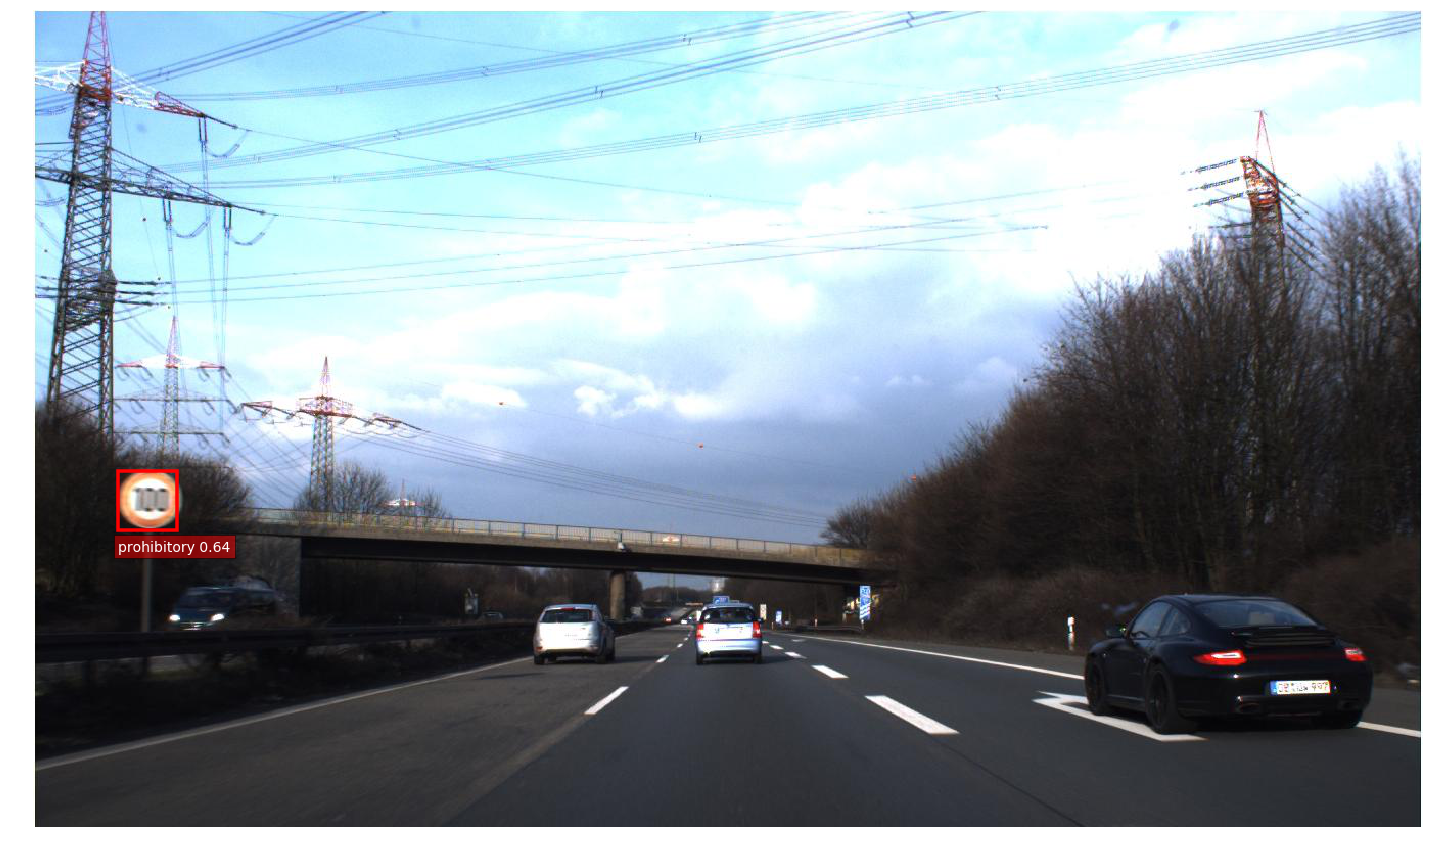

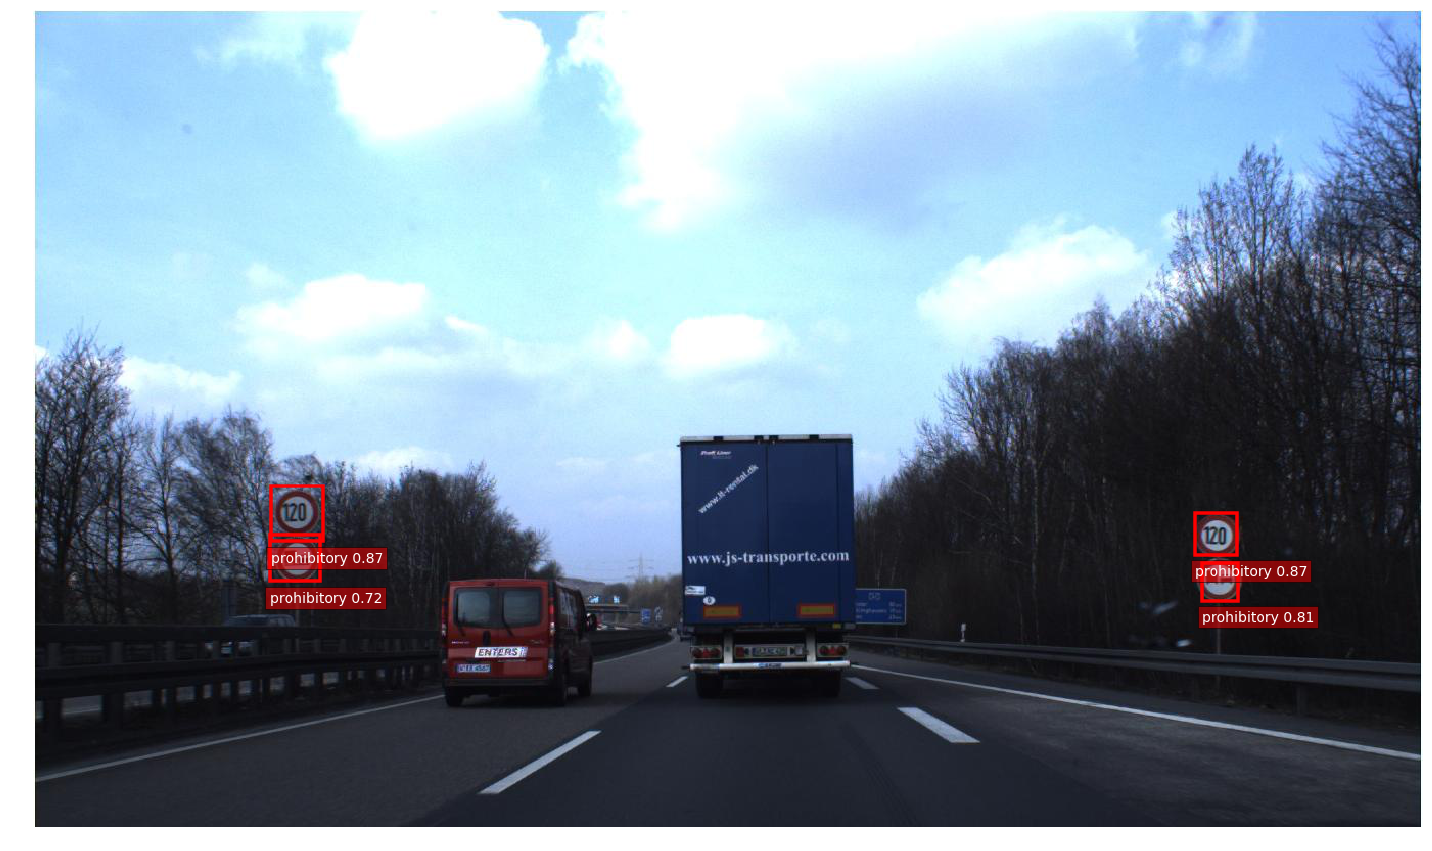

In [13]:
min_score_thresh = 0.5
for image_path in TEST_IMAGE_PATHS:
    fig, ax = plt.subplots(figsize=(20, 20))
    image = Image.open(image_path)
    image_name = os.path.basename(image_path)
    width, height = image.size
    ax.imshow(image)
    
    image_np = load_image_into_numpy_array(image)
    image_np = image_np[:,:,::-1] # rgb -> bgr
    pred_results = tfnet.return_predict(image_np)

    for idx, det in enumerate(pred_results):
        score = det['confidence']
        if score > min_score_thresh:
            bbox = det['topleft']['x'], det['topleft']['y'], det['bottomright']['x'], det['bottomright']['y']
            label = get_label_id(det['label'])
            plot_rectangle(bbox,ax,category_index[label]['name'],'red', score)
    plt.draw()
    fig.tight_layout()
    plt.axis('off')
    plt.show()